# Feature extraction and reverse image search using pre-trained CNN

This notebook deals with the procedure of analyzing a large set of images using a pre-trained convolutional network, extracting feature vectors (activations of last layer) for each one which represent each image. 

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image. 

### 1. Import necessary libraries and write main functions


In [9]:
import os
import graphviz
import keras
import tensorflow
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image 
import time
import random
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors


def conv_model(model_name='resnet',show_model=False):
    if model_name=='inception_v3':
        from keras.applications.inception_v3 import InceptionV3
        model = tensorflow.keras.applications.InceptionV3(weights='imagenet', include_top=True)
    elif model_name=='vgg16':
        from tensorflow.keras.applications.vgg16 import VGG16
        model = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=True)
    elif model_name=='xception':
        from keras.applications.xception import Xception
        model = tensorflow.keras.applications.Xception(weights='imagenet', include_top=True)
    elif model_name=='resnet':
        from keras_applications.resnet import ResNet50
        model = tensorflow.keras.applications.ResNet50(weights='imagenet', include_top=True)
    elif model_name=='vgg':
        model = tensorflow.keras.applications.VGG19(weights='imagenet', include_top=True)
    elif model_name=='mobile':
        from keras.applications.mobilenet import MobileNet
        model = tensorflow.keras.applications.MobileNet(weights='imagenet', include_top=True)
    else:
        print('Incorrect name')
    if show_model==True:
        model.summary()
    return model


def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()

def get_neighbors(feature_vector,feature_vectors, top=8):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    
    nbrs =  NearestNeighbors(n_neighbors=5,algorithm='ball_tree').fit(feature_vectors)
    distances, indices = nbrs.kneighbors(feature_vector)
    
    return distances, indices        


def load_image(path,model_name='resnet'):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if model=='inception_v3':
        from keras.applications.inception_v3 import preprocess_input as process_inception
        x=preprocess_inception(x)
    elif model_name=='vgg16':
        from keras.applications.vgg16 import preprocess_input as process_vgg16
        x=process_vgg16(x)
    elif model_name=='xception':
        from keras.applications.xception import preprocess_input as process_xception
        x=process_xception(x)
    elif model_name=='resnet':
        from keras_applications.resnet import preprocess_input as process_resnet
        x=process_resnet(x)
    elif model_name=='vgg':
        from keras.applications.vgg19 import preprocess_input as process_vgg
        x=process_vgg(x)
    elif model_name=='mobile':
        from keras.applications.mobilenet import preprocess_input as process_mobile
        x=process_mobile(x)  
    else:
        print('Incorrect name')
    return img, x

def img_to_conv_features(model_name,model,x):
    if model_name=='inception_v3':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
    elif model_name=='vgg16':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
        feat = feat_extractor.predict(x)
    elif model_name=='xception':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
    elif model_name=='resnet':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
        feat = feat_extractor.predict(x)
    elif model_name=='vgg':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
    else:
        print('Incorrect name')
    feat=feat_extractor(x)
    return feat
def imgs_to_conv_features(model_name,model,images,image_path):
    if model_name=='inception_v3':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
    elif model_name=='vgg16':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
    elif model_name=='xception':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("avg_pool").output)
    elif model_name=='resnet':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
    elif model_name=='vgg':
        feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
    else:
        print('Incorrect name')
    tic = time.process_time()

    every=20
    features = []
    for i, image_path in enumerate(images):

        if i % every == 0:
            toc = time.process_time()
            elap = toc-tic;
            remaining_time=(len(images)-i)*elap/every
            hours=remaining_time//3600
            minutes=remaining_time//60
            seconds=remaining_time%60
            print("analyzing image %d / %d. Time/%d pics: %4.4f seconds." % (i, len(images),every,elap))
            print('Remaining time: %d hours %d minutes %d sec.' %(hours,minutes,seconds))
            
            tic = time.process_time()
        img, x = load_image(path=image_path,model_name=model_name);
        #print(image_path+"\n")
        feat = feat_extractor.predict(x)[0]
        features.append(feat)

    print('finished extracting features for %d images' % len(images))
    return features


def choose_imgs(max_num_images=2000,images_path='C:\\Users\\Rami\\Desktop\\PetImages\\dogs-vs-cats'):
    image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
    print(np.shape(images))
    if max_num_images < len(images):
        images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

    print("keeping %d images to analyze" % len(images))
    return images
def reduce_PCA(features,n_components=40):
    features = np.array(features)
    pca = PCA(n_components=n_components)
    pca.fit(features)
    pca_features = pca.transform(features)
    return pca_features

def plot_activation_layer(feature_vector):
    
    print(np.shape(feature_vector))
    feature_vector=np.array(feature_vector)
    feature_vector=feature_vector.flatten()
    plt.figure(figsize=(16,4))
    plt.ylabel('Activations of last layer (fc2)')
    plt.xlabel('## of neuron')
    plt.plot(feature_vector)
    plt.show()
    plt.close()
    
    return 0

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Here we start to set which image we want to compare to which folder of images. We can also choose the model and get some useful messages

In [2]:
### PATH TO IMAGE THAT IS TO BE COMPARED (OBSERVATION)
path='C:\\Users\\Rami\\Desktop\\PetImages\\dogs-vs-cats\\cat_.jpg' 

### PATH TO IMAGES FOLDER (SIMULATIONS))
image_path='C:\\Users\\Rami\\Desktop\\PetImages\\dogs-vs-cats'

### Name of Neural network.  Options are inception_v3,vgg16,vgg (for vgg19),xception. later our own c.n.n could be added
model_name='vgg16'

### Load the model (kind of heavy computationally since it loads ~100 milion numbers.)
model=conv_model(model_name=model_name)  

#Print model's name
print(model)

# img: photo of image inputed in the network (for visual purposes), 
#x: an input preprocessed to be inserted in the networks input.
img, x = load_image(path=path,model_name=model_name)
#making it a numpy array for easier manipulation
x=np.array(x)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### A little bit about the context

The networks that are implemented are some of the top performing on the classification contest by imagenet on classifying  
pictures on 1000 labels , when fed with a dataset 1.2 milion pictures. 
Since the machine learning consists of 


Step 1: Designing the architechture of your network


(how many layers, how many neurons (units) does a layer have, which
connections exist between adjacent layers, and what is the mathematical operation that a layer operates on the input in order
to produce the output (activation function) which wiill be fed to the next layer.

Step 2: Train the model

  Start by initializing some numbers for all weight (for example set them all to 0), and then try to find optimal values
for these parameters, the weights between the connections. The basic idea on how to find these optimal values,
is to define a loss function which represents  how well the programm is achieving what we want it to do. We want the loss
function to be small when the program is accomplishing the task (classifying images with labels correctly)
and we want the loss to be large when the program is failing (you give it a picture of a cat, and it tells you its a dog).
Since the loss function of the CNN is dependant by some mathematic expression to the weights of the network, minimizing is
an optimization problem which can be solved by just walking towards the negative derivative of L(W1,w2..,W_n).
A common algorithm that does this downhill walk on ths multidimensional space of weights in order
to find the optimal values of the weights is stohastic gradient descent (SGD)


Step 3: Your model is trained now and has small loss. 

Now the cnn can receive new input images and be able to produce "signature-information" containing feature vectors.


Propagate the input x in the network and return the second-last layer, commonly called feature vector (denamed by 
  variable feature here). The feature vector has ~10^3 dimensions and simply consists of all the weight between the last 2 
layers.  It is common in convolutional neural network (CNN) architecture that the two last layers are fully
conected, while the rest of the layers inside the convolutional network (convolutions,max pool, avg pool, etc.) can skip
connections from a layer to the next one.


Remember that the networks that we are implementing have very high accuracy on classifying 1000 different types of objects
which means that the layer before the last inputs some vector and outputs it's activation function to the last layer,
which is the 1000 element layer of the predictions. Because of this, the feature vector is a better representation of the 
image's content than simply the 2D X3 (rgb) matrix of the colors consisting the image in order to assess a similarity measure.


We dont use the last layer of the network (predictions) but the second last (feature vector)

tf.Tensor([[0.         0.         0.04190123 ... 0.         0.         0.63443255]], shape=(1, 4096), dtype=float32)
(1, 4096)


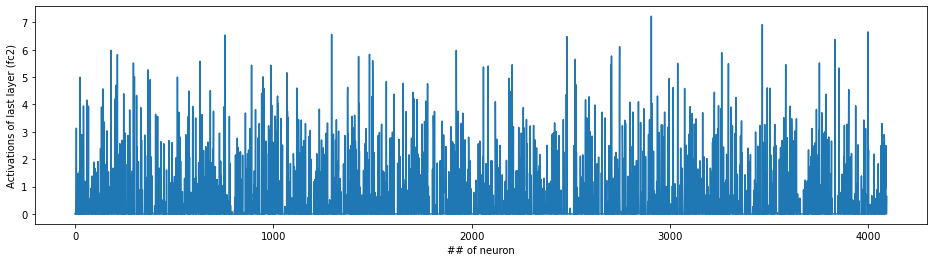

(23701,)
keeping 20 images to analyze
images shape: (20,)
analyzing image 0 / 20. Time/20 pics: 0.0000 seconds.
Remaining time: 0 hours 0 minutes 0 sec.
finished extracting features for 20 images
features shape (20, 4096)
(1, 4096)


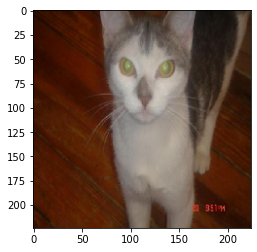

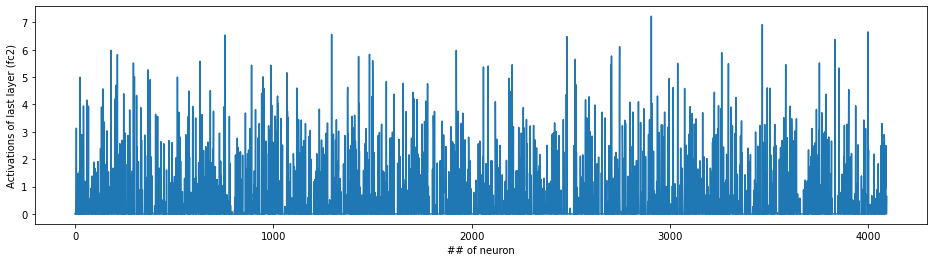

0

In [3]:
#function that takes an image and converts it to it's feature vector
feature=img_to_conv_features(model_name=model_name,model=model,x=x)
print(feature)
feature_vector=np.array(feature)

# Plot the activations / feature layer
plot_activation_layer(feature_vector=feature)

# Plot the image which corresponds to those weights
plt.imshow(img)

# Assign the folder which contains the images dataset and the max amount of images accepted.
images=choose_imgs(max_num_images=20)
print('images shape:',np.shape(images))

## Heavy computationally part, calculate the feature vector for each and one image in our dataset.
features=imgs_to_conv_features(model_name=model_name,model=model,images=images,image_path=image_path)
print('features shape',np.shape(features))


#   Now there is the choice to use this tool called Principal Component Analysis which can be thought off a tool that takes this
#arbitary feature vector and tries to reduce the dimensionality. It does so by changing the coordinate basis in another 
#coordinate system of lower dimensionality/ a subset of the initial (large) feature vector space. 
#By reducing the amount of dimensions we lose accuracy on explaining the variance of the data along the axes, but we reduce
#computation time.
use_PCA=False
n_components=200
if use_PCA==True:
    # dimension checking
#     print(np.shape(features))
#     print(np.shape(feature))
#     print(np.shape(np.vstack((features,feature))))
    
    # Make the dimensionality reduction based on the variance of the feature vectors for both the dataset and the observation.
    full_features=np.vstack((feature,features))
    reduced_full_features=reduce_PCA(features,n_components=n_components)
    
    reduced_feature=reduced_full_features[0,:]
    reduced_features=reduced_full_features[1:,:]
    # Dimension checking
#     print(np.shape(reduced_feature))
#     print(np.shape(reduced_features))
#     print(np.shape(reduced_full_features))
elif use_PCA==False:
    #Just use the long featured vectors in this case
    reduced_features=features
    reduced_feature=feature
    
#print('features shape (after pca reduc)',np.shape(features))

feature_vector=np.array(feature_vector)
#Plot the new PCA-reduced representation of the feature vector.
plot_activation_layer(feature_vector=reduced_feature)

### Searching for patterns/similarities in feature vectors and  calculating similarity index and plotting.

This is accomplished through finding some kind of metric to tell how do those vectors look like. Here you can see me employing two methods, the cosine distance defined as

$$
\begin{equation}
\cos{\theta}=\frac{u \cdot v}{u \times v} 
\end{equation}
$$

But on scipy documentation the function distance.cosine return the similarity which can be defined related to the cosine distance as:
$$
\begin{equation}
similarity=1-\cos{\theta}=1-\frac{u \cdot v}{u \times v} 
\end{equation}
$$

Similar pictures --> Similarity=0

Unsimilar pictures --> Similarity=2
.

On the following we measure the similarity between our observation-simulations pictures and we show the 5 lowest similarity 
pictures.

### Cosine Distance

0.41691625118255615
0.8887272030115128
Cosine distance between target picture and 1 best match is:0.42
Cosine distance between target picture and 2 best match is:0.47
Cosine distance between target picture and 3 best match is:0.50
Cosine distance between target picture and 4 best match is:0.52
Cosine distance between target picture and 5 best match is:0.55


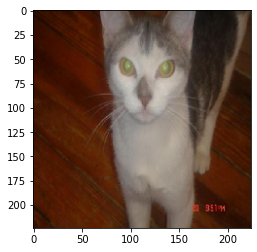

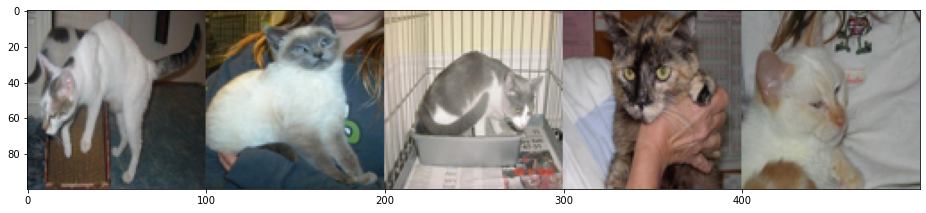

In [4]:

similar_idx = [ distance.cosine(reduced_feature, reduced_feature_i) for reduced_feature_i in reduced_features ]
print(np.amin(similar_idx))
print(np.amax(similar_idx))
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:5]
# load all the similarity results as thumbnails of height 100
thumbs = []
i=0
for idx in idx_closest:
    i+=1
    img1 = image.load_img(images[idx])
    img1 = img1.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img1)
    dist=distance.cosine(reduced_feature,reduced_features[idx])
    print("Cosine distance between target picture and %d best match is:%1.2f"%(i,dist))

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.imshow(img)
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


Another way to find the closest pictures could also be to say: let's find the pictures in the dataset which are the closest to our own by distance on their vector space. These ones with the least distance will be classified as best matches for the reverse image search. We will use the 5-nearest-neighbours algorithm, which in general for k neighbours is called kNN (k nearest neighbours).

### K-nearest neighbors algorithm


In [5]:
distances,idx_closest=get_neighbors(feature_vector=feature_vector,feature_vectors=features)
distances=distances.flatten()
idx_closest=idx_closest.flatten()

The closest distances were:
[70.44207994 71.2626933  77.12065142 78.24916795 78.61803337]
for neighbors with indexes respectively:
[13 16 17 12 10]
1 closest with distance 7.04e+01
2 closest with distance 7.13e+01
3 closest with distance 7.71e+01
4 closest with distance 7.82e+01
5 closest with distance 7.86e+01


Text(0.5, 1.0, 'result images')

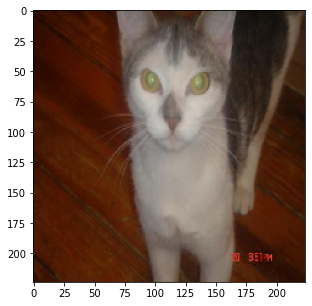

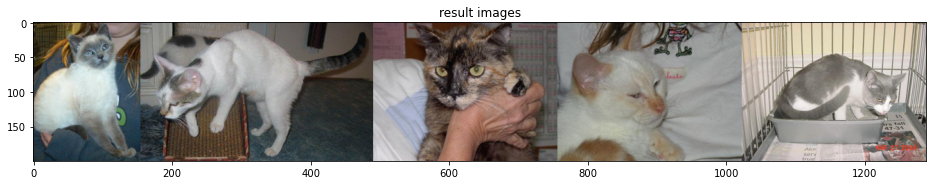

In [6]:

distances=np.array(distances)
print('The closest distances were:')
print(distances)
print('for neighbors with indexes respectively:')
print(idx_closest)
i=0
for _ in idx_closest:
    i+=1
    print('%d closest with distance %1.2e'%(int(i),distances[i-1]))

    
query_image = img

results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)

# display the resulting images
plt.figure(figsize = (16,12))

plt.imshow(results_image)
plt.title("result images")



### All  the code in one cell without many outputs

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

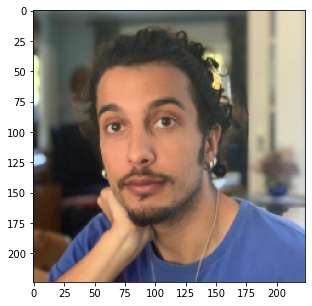

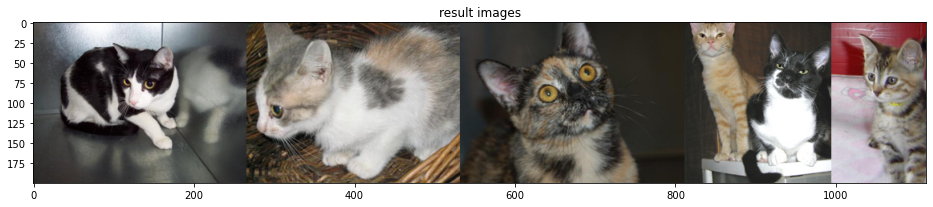

In [7]:
path='C:\\Users\\Rami\\Downloads\\rami2.jpg' 
image_path='C:\\Users\\Rami\\Desktop\\PetImages\\dogs-vs-cats'
max_num_images=40
model_name='vgg16'

use_PCA=False
n_components=100

distance_metric='knn'

model=conv_model(model_name=model_name)  
img, x = load_image(path=path,model_name=model_name)
x=np.array(x)
feature=img_to_conv_features(model_name=model_name,model=model,x=x)
feature=np.array(feature)
images=choose_imgs(max_num_images=max_num_images)
features=imgs_to_conv_features(model_name=model_name,model=model,images=images,image_path=image_path)

if use_PCA==True:
    full_features=np.vstack((feature,features))
    reduced_full_features=reduce_PCA(features,n_components=n_components)
    
    reduced_feature=reduced_full_features[0,:]
    reduced_features=reduced_full_features[1:,:]
elif use_PCA==False:
    reduced_features=features
    reduced_feature=feature
    
reduced_feature=np.array(reduced_feature)
if distance_metric=='cosine':
    similar_idx = [ distance.cosine(reduced_feature, reduced_feature_i) for reduced_feature_i in reduced_features ]
    print(np.amin(similar_idx))
    print(np.amax(similar_idx))
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[0:5]
    # load all the similarity results as thumbnails of height 100
    thumbs = []
    i=0
    for idx in idx_closest:
        i+=1
        img1 = image.load_img(images[idx])
        img1 = img1.resize((int(img.width * 100 / img.height), 100))
        thumbs.append(img1)
        dist=distance.cosine(reduced_feature,reduced_features[idx])
        print("%d closest with distance %1.2f'%"%(i,dist))

    # concatenate the images into a single image
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

    # show the image
    plt.imshow(img)
    plt.figure(figsize = (16,12))
    plt.imshow(concat_image)



elif distance_metric=='knn':
    distances,idx_closest=get_neighbors(feature_vector=feature_vector,feature_vectors=features)
    distances=distances.flatten()
    idx_closest=idx_closest.flatten()




    distances=np.array(distances)
    print('The closest distances were:')
    print(distances)
    print('for neighbors with indexes respectively:')
    print(idx_closest)
    i=0
    for _ in idx_closest:
        i+=1
        print('%d closest with distance %1.2e'%(int(i),distances[i-1]))


    query_image = img


    results_image = get_concatenated_images(idx_closest, 200)

    # display the query image
    plt.figure(figsize = (5,5))
    plt.imshow(query_image)

    # display the resulting images
    plt.figure(figsize = (16,12))

    plt.imshow(results_image)
    plt.title("result images")



Text(0.5, 1.0, '5 closest matches')

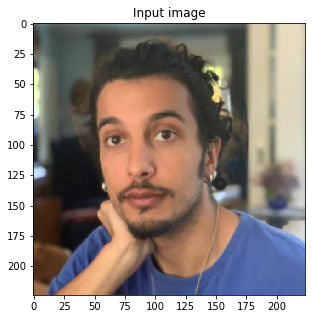

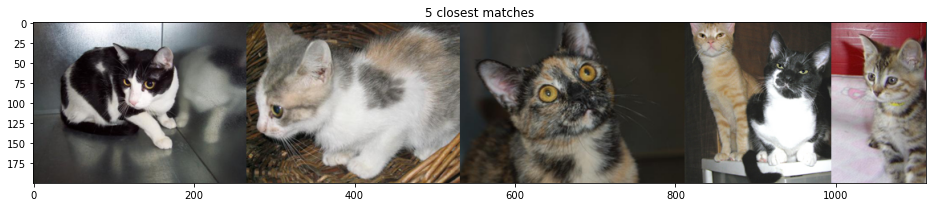

In [10]:

    # display the query image
    plt.figure(figsize = (5,5))
    plt.title('Input image')
    plt.imshow(query_image)

    # display the resulting images
    plt.figure(figsize = (16,12))

    plt.imshow(results_image)
    plt.title("5 closest matches")
